In [1]:
from google.colab import drive
import torch.nn.functional
import gdown
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import os
import zipfile
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.utils.data as data
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/dataset'
os.listdir(data_dir)

Mounted at /content/drive


['train', 'test', 'val']

In [3]:
!cp -r '/content/drive/MyDrive/dataset' /content/

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.conv3 = nn.Conv2d(64, 128, 5, 1)
        self.conv4 = nn.Conv2d(128, 256, 5, 1)
        self.conv5 = nn.Conv2d(256, 512, 5, 1)
        self.fc1 = nn.Linear(512 * 5 * 5, 128)
        self.output = nn.Linear(128, 15)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = torch.nn.functional.relu(self.conv3(x))
        x = torch.nn.functional.relu(self.conv4(x))
        x = torch.nn.functional.relu(self.conv5(x))
        x = torch.flatten(x, 1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.output(x)
        x = torch.nn.functional.log_softmax(x, dim=1)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_sizes = [16,32]
lr_list = [0.1, 0.01]
num_epoch = 100
checkpoint_dir = '/content/checkpoints'

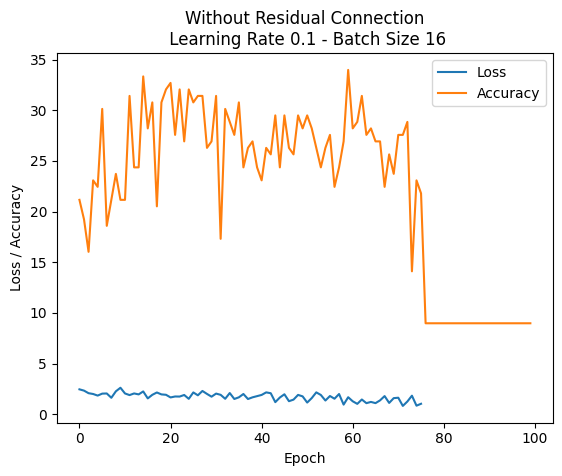

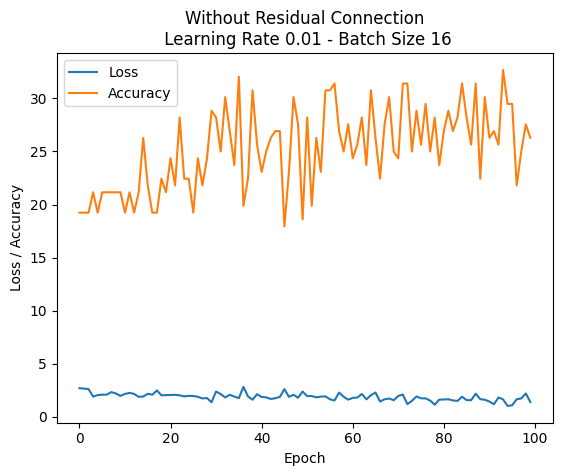

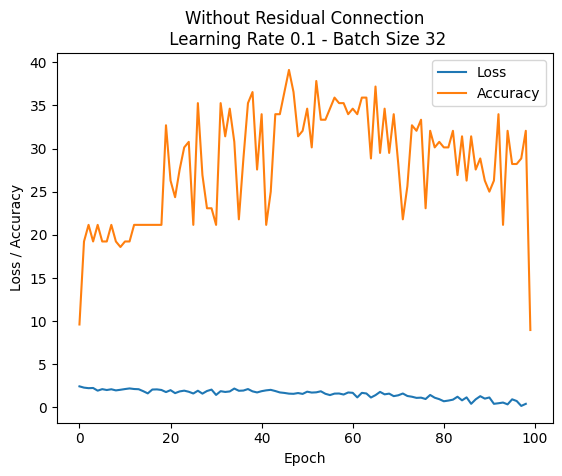

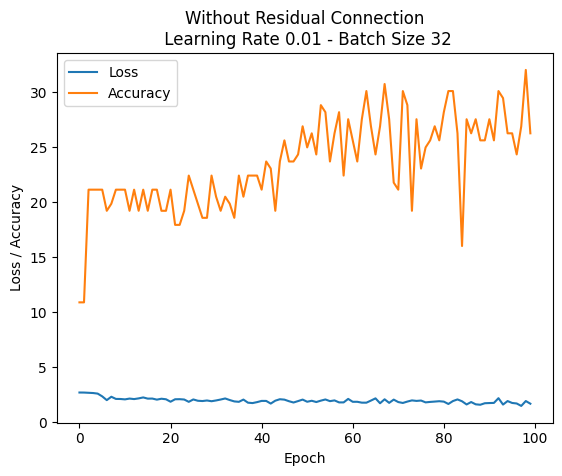

In [ ]:
loss_dict = {}
accuracy_dict = {}
batch_size_loss_dict = {}
batch_size_acc_dict = {}
confusion_matrix_dict = {}
best_confusion_matrix = None
best_lr = None
best_batch_size = None
best_val_accuracy = 0
epoch_acc_list = []

for batch_size in batch_sizes:
    transform = transforms.Compose([
        transforms.Resize((80, 80)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_dataset = ImageFolder('/content/dataset/train', transform=transform)
    test_dataset = ImageFolder('/content/dataset/test', transform=transform)
    valid_dataset = ImageFolder('/content/dataset/val', transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    for lr in lr_list:
      model = CNN().to(device)
      optimizer = torch.optim.SGD(model.parameters(), lr=lr)
      criterion = nn.CrossEntropyLoss()

      loss_list = []
      acc_list = []

      n_total_steps = len(train_loader)

      for epoch in range(num_epoch):
        for i, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        model.eval()
        correct = 0
        total = 0
        conf_mat = np.zeros((8, 8))
        with torch.no_grad():
          for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            conf_mat += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=list(range(8)))
            
          acc = 100 * correct / total
          acc_list.append(acc)
          loss_list.append(loss.item())
      
      if acc > best_val_accuracy:
        best_val_accuracy = acc
        best_lr = lr
        best_batch_size = batch_size
        best_confusion_matrix = conf_mat.copy()
      checkpoint_path = os.path.join(checkpoint_dir, f'wo_residual_model_lr_{lr}_batch_size_{batch_size}.pt')
      torch.save(model.state_dict(), checkpoint_path)

      # Update loss and accuracy dictionaries for the current batch size
      loss_dict[str(lr)] = loss_list.copy()
      accuracy_dict[str(lr)] = acc_list.copy()
      if batch_size in batch_size_loss_dict:
        batch_size_loss_dict[batch_size][str(lr)] = loss_list.copy()
        batch_size_acc_dict[batch_size][str(lr)] = acc_list.copy()
      else:
        batch_size_loss_dict[batch_size] = {str(lr): loss_list.copy()}
        batch_size_acc_dict[batch_size] = {str(lr): acc_list.copy()}

      # Plot the loss and accuracy curves for the current batch size and learning rate
      plt.figure()
      plt.plot(loss_list, label="Loss")
      plt.plot(acc_list, label="Accuracy")
      plt.title(f"Without Residual Connection\n Learning Rate {lr} - Batch Size {batch_size}")
      plt.xlabel("Epoch")
      plt.ylabel("Loss / Accuracy")
      plt.legend()
      plt.show()


   


In [ ]:
print(best_val_accuracy)
best_confusion_matrix

26.28205128205128


array([[ 1.,  3.,  1.,  4.,  3.,  2.,  0.,  0.],
       [ 1., 19.,  4.,  2.,  4.,  3.,  0.,  0.],
       [ 0.,  1.,  6.,  1.,  4.,  3.,  0.,  0.],
       [ 1.,  6.,  4.,  3.,  8.,  8.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  8.,  5.,  0.,  2.],
       [ 0.,  4.,  3.,  0.,  6.,  4.,  0.,  0.],
       [ 0.,  0.,  1.,  3.,  7.,  4.,  0.,  0.],
       [ 0.,  3.,  1.,  3.,  7.,  1.,  0.,  0.]])

In [ ]:
# Load the saved model with the best validation accuracy
model = CNN().to(device)
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, f'wo_residual_model_lr_{best_lr}_batch_size_{best_batch_size}.pt')))

# Evaluate the model on the test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test accuracy: {test_accuracy:.2f}")

Test accuracy: 21.60


In [ ]:
#save best parameters for without residual
wo_best_accuracy = best_val_accuracy
wo_best_lr = best_lr
wo_best_confusion_matrix = best_confusion_matrix
wo_best_batch_size = best_batch_size

In [ ]:
print('best accuracy', wo_best_accuracy)
print('best lr', wo_best_lr)
print('best batch_size', wo_best_batch_size)

best accuracy 26.28205128205128
best lr 0.01
best batch_size 16


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()
        
    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.res1 = ResidualBlock(32, 64)
        self.res2 = ResidualBlock(64, 128)
        self.res3 = ResidualBlock(128, 256)
        self.res4 = ResidualBlock(256, 512)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 128)
        self.output = nn.Linear(128, 15)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool(torch.nn.functional.relu(x))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.output(x)
        x = torch.nn.functional.log_softmax(x, dim=1)
        return x 


In [ ]:
num_epoch = 100

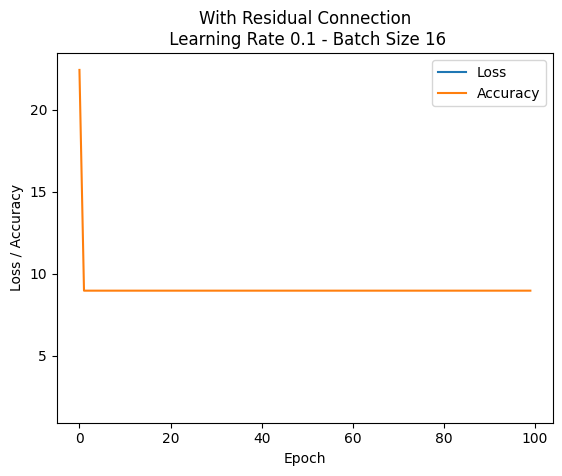

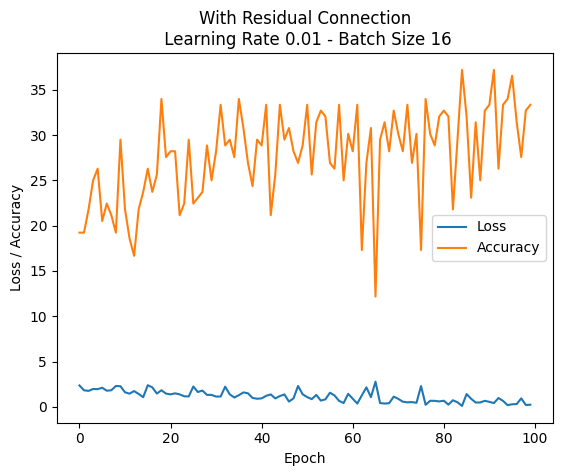

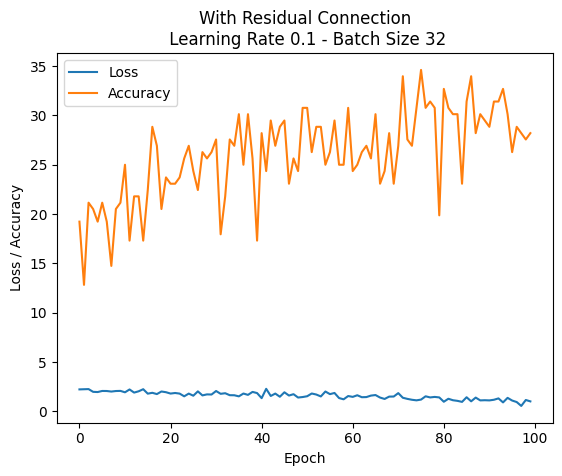

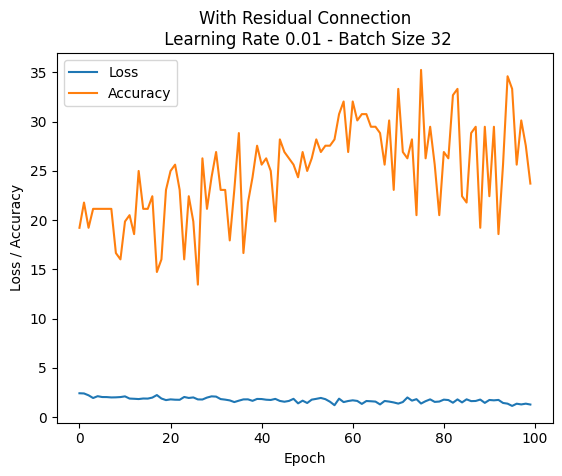

In [ ]:
loss_dict = {}
accuracy_dict = {}
batch_size_loss_dict = {}
batch_size_acc_dict = {}
confusion_matrix_dict = {}
best_confusion_matrix = None
best_lr = None
best_batch_size = None
best_val_accuracy = 0
epoch_acc_list = []

for batch_size in batch_sizes:
    transform = transforms.Compose([
        transforms.Resize((30, 30)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_dataset = ImageFolder('/content/dataset/train', transform=transform)
    test_dataset = ImageFolder('/content/dataset/test', transform=transform)
    valid_dataset = ImageFolder('/content/dataset/val', transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    for lr in lr_list:
      model = CNN().to(device)
      optimizer = torch.optim.SGD(model.parameters(), lr=lr)
      criterion = nn.CrossEntropyLoss()

      loss_list = []
      acc_list = []

      n_total_steps = len(train_loader)

      for epoch in range(num_epoch):
        for i, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        model.eval()
        correct = 0
        total = 0
        conf_mat = np.zeros((8, 8))
        with torch.no_grad():
          for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            conf_mat += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=list(range(8)))
            
          acc = 100 * correct / total
          acc_list.append(acc)
          loss_list.append(loss.item())
      
      if acc > best_val_accuracy:
        best_val_accuracy = acc
        best_lr = lr
        best_batch_size = batch_size
        best_confusion_matrix = conf_mat.copy()
      checkpoint_path = os.path.join(checkpoint_dir, f'w_residual_model_lr_{lr}_batch_size_{batch_size}.pt')
      torch.save(model.state_dict(), checkpoint_path)

      # Update loss and accuracy dictionaries for the current batch size
      loss_dict[str(lr)] = loss_list.copy()
      accuracy_dict[str(lr)] = acc_list.copy()
      if batch_size in batch_size_loss_dict:
        batch_size_loss_dict[batch_size][str(lr)] = loss_list.copy()
        batch_size_acc_dict[batch_size][str(lr)] = acc_list.copy()
      else:
        batch_size_loss_dict[batch_size] = {str(lr): loss_list.copy()}
        batch_size_acc_dict[batch_size] = {str(lr): acc_list.copy()}

      # Plot the loss and accuracy curves for the current batch size and learning rate
      plt.figure()
      plt.plot(loss_list, label="Loss")
      plt.plot(acc_list, label="Accuracy")
      plt.title(f"With Residual Connection\n Learning Rate {lr} - Batch Size {batch_size}")
      plt.xlabel("Epoch")
      plt.ylabel("Loss / Accuracy")
      plt.legend()
      plt.show()

In [ ]:
#save best parameters for without residual
w_best_accuracy = best_val_accuracy
w_best_lr = best_lr
w_best_confusion_matrix = best_confusion_matrix
w_best_batch_size = best_batch_size

In [ ]:
print('best accuracy', w_best_accuracy)
print('best lr', w_best_lr)
print('best batch_size', w_best_batch_size)

best accuracy 33.333333333333336
best lr 0.01
best batch_size 16


In [ ]:
load_path = None
if (wo_best_accuracy > w_best_accuracy):
  print('Without Residual is better model')
  best_val_accuracy = wo_best_accuracy
  best_lr = wo_best_lr
  best_confusion_matrix = wo_best_confusion_matrix
  best_batch_size = wo_best_batch_size
  load_path = f'wo_residual_model_lr_{best_lr}_batch_size_{best_batch_size}.pt'

else:
  print('With Residual is better model')
  load_path = f'w_residual_model_lr_{best_lr}_batch_size_{best_batch_size}.pt'

print(load_path)

With Residual is better model
w_residual_model_lr_0.01_batch_size_16.pt


In [ ]:
# Load the saved model with the best validation accuracy
model = CNN().to(device)
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, load_path)))

# Evaluate the model on the test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test accuracy: {test_accuracy:.2f}")

Test accuracy: 32.10


In [ ]:
print(best_val_accuracy)
best_confusion_matrix

33.333333333333336


array([[ 4.,  3.,  2.,  1.,  2.,  1.,  1.,  0.],
       [ 0., 20.,  6.,  3.,  0.,  0.,  3.,  1.],
       [ 0.,  2., 11.,  1.,  0.,  0.,  0.,  1.],
       [ 3.,  5.,  8.,  4.,  2.,  1.,  4.,  3.],
       [ 1.,  0.,  4.,  2.,  1.,  2.,  5.,  2.],
       [ 0.,  2.,  4.,  1.,  1.,  4.,  2.,  3.],
       [ 0.,  1.,  5.,  1.,  2.,  1.,  3.,  2.],
       [ 2.,  0.,  3.,  1.,  1.,  1.,  2.,  5.]])

## PART 2

In [13]:
num_epochs = 20
batch_size = 16

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
        transforms.Resize((30, 30)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = ImageFolder('/content/dataset/train', transform=transform)
test_dataset = ImageFolder('/content/dataset/test', transform=transform)
valid_dataset = ImageFolder('/content/dataset/val', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False)


model = models.resnet18(pretrained=True)

# Freeze all layers except the last FC layer
for param in model.parameters():
    param.requires_grad = False

num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


def train(model, dataloader, criterion, optimizer): #train with the given model and dataloader
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc



#Train the model on the FC layer only:
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

train_loss_for_fc_only = train_loss
train_acc_for_fc_only = train_acc

def evaluate(model, dataloader): #evaluate the model with the given model and dataloader
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    conf_mat = np.zeros((8, 8))
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            conf_mat += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=list(range(8)))

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc, conf_mat

valid_loss, valid_acc, conf_mat_fc_only_val = evaluate(model, valid_loader)
print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.2f}%")

valid_loss_for_fc_only = valid_loss
valid_acc_for_fc_only = valid_acc

test_loss, test_acc, conf_mat_fc_only = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

test_loss_for_fc_only = test_loss
test_acc_for_fc_only = test_acc
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
# Reset the model before unfreezing the last two convolutional layers
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# Unfreeze the last two convolutional layers, train the last two convolutional layers along with the FC layer
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.layer4.requires_grad = True
model.layer3.requires_grad = True
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

train_loss_for_last2layers = train_loss
train_acc_for_last2layers = train_acc


valid_loss, valid_acc, conf_mat_last2layers_val = evaluate(model, valid_loader)
print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.2f}%")

valid_loss_for_last2layers = valid_loss
valid_acc_for_last2layers = valid_acc

test_loss, test_acc, conf_mat_last2layers = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

test_loss_for_last2layers = test_loss
test_acc_for_last2layers = test_acc



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 - Training Loss: 2.2658, Training Accuracy: 19.11%
Epoch 2/20 - Training Loss: 1.8771, Training Accuracy: 30.36%
Epoch 3/20 - Training Loss: 1.7858, Training Accuracy: 34.18%
Epoch 4/20 - Training Loss: 1.6919, Training Accuracy: 34.61%
Epoch 5/20 - Training Loss: 1.5963, Training Accuracy: 41.19%
Epoch 6/20 - Training Loss: 1.5571, Training Accuracy: 43.31%
Epoch 7/20 - Training Loss: 1.4732, Training Accuracy: 48.20%
Epoch 8/20 - Training Loss: 1.4706, Training Accuracy: 44.80%
Epoch 9/20 - Training Loss: 1.4369, Training Accuracy: 50.11%
Epoch 10/20 - Training Loss: 1.4348, Training Accuracy: 49.89%
Epoch 11/20 - Training Loss: 1.4156, Training Accuracy: 46.71%
Epoch 12/20 - Training Loss: 1.3622, Training Accuracy: 50.74%
Epoch 13/20 - Training Loss: 1.2935, Training Accuracy: 53.29%
Epoch 14/20 - Training Loss: 1.4752, Training Accuracy: 47.56%
Epoch 15/20 - Training Loss: 1.3724, Training Accuracy: 51.38%
Epoch 16/20 - Training Loss: 1.3353, Training Accuracy: 50.74%
E

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 - Training Loss: 2.2941, Training Accuracy: 18.05%
Epoch 2/20 - Training Loss: 1.9673, Training Accuracy: 30.15%
Epoch 3/20 - Training Loss: 1.7643, Training Accuracy: 35.88%
Epoch 4/20 - Training Loss: 1.6683, Training Accuracy: 41.40%
Epoch 5/20 - Training Loss: 1.6226, Training Accuracy: 41.19%
Epoch 6/20 - Training Loss: 1.4775, Training Accuracy: 47.56%
Epoch 7/20 - Training Loss: 1.5074, Training Accuracy: 45.86%
Epoch 8/20 - Training Loss: 1.4721, Training Accuracy: 48.62%
Epoch 9/20 - Training Loss: 1.4048, Training Accuracy: 52.44%
Epoch 10/20 - Training Loss: 1.4240, Training Accuracy: 48.20%
Epoch 11/20 - Training Loss: 1.3775, Training Accuracy: 48.41%
Epoch 12/20 - Training Loss: 1.3191, Training Accuracy: 54.78%
Epoch 13/20 - Training Loss: 1.3943, Training Accuracy: 50.74%
Epoch 14/20 - Training Loss: 1.3571, Training Accuracy: 53.08%
Epoch 15/20 - Training Loss: 1.3923, Training Accuracy: 51.17%
Epoch 16/20 - Training Loss: 1.2955, Training Accuracy: 52.02%
E

In [16]:
# Print results for training only FC layer
print("Results for training only FC layer:")
print("----------------------------------------------------------")
print("|   Metric    |   Training   |  Validation  |    Test    |")
print("|-------------|--------------|--------------|------------|")
print("|   Loss      |  {:10.4f}  |  {:10.4f}  | {:10.4f} |".format(train_loss_for_fc_only, valid_loss_for_fc_only, test_loss_for_fc_only))
print("|  Accuracy   |   {:8.2f}%  |   {:7.2f}%   |  {:8.2f}% |".format(train_acc_for_fc_only, valid_acc_for_fc_only, test_acc_for_fc_only))
print("----------------------------------------------------------")

# Print results for training last two convolutional layers and FC layer
print("\nResults for training last two convolutional layers and FC layer:")
print("----------------------------------------------------------")
print("|   Metric    |   Training   |  Validation  |    Test    |")
print("|-------------|--------------|--------------|------------|")
print("|   Loss      |  {:10.4f}  |  {:10.4f}  | {:10.4f} |".format(train_loss_for_last2layers, valid_loss_for_last2layers, test_loss_for_last2layers))
print("|  Accuracy   |   {:8.2f}%  |   {:7.2f}%   |  {:8.2f}% |".format(train_acc_for_last2layers, valid_acc_for_last2layers, test_acc_for_last2layers))
print("----------------------------------------------------------")



Results for training only FC layer:
----------------------------------------------------------
|   Metric    |   Training   |  Validation  |    Test    |
|-------------|--------------|--------------|------------|
|   Loss      |      1.3140  |      1.9948  |     2.3008 |
|  Accuracy   |      52.44%  |     37.82%   |     32.10% |
----------------------------------------------------------

Results for training last two convolutional layers and FC layer:
----------------------------------------------------------
|   Metric    |   Training   |  Validation  |    Test    |
|-------------|--------------|--------------|------------|
|   Loss      |      1.2764  |      2.0061  |     2.3257 |
|  Accuracy   |      52.44%  |     35.26%   |     29.63% |
----------------------------------------------------------


In [17]:
print('Confusion Matrix for FC only')
conf_mat_fc_only

Confusion Matrix for FC only


array([[ 2.,  5.,  0.,  6.,  1.,  1.,  0.,  0.],
       [ 4., 24.,  1.,  3.,  0.,  3.,  0.,  0.],
       [ 1.,  3.,  1.,  6.,  1.,  3.,  0.,  1.],
       [ 1.,  7.,  3., 17.,  1.,  2.,  0.,  0.],
       [ 2.,  5.,  0.,  2.,  1.,  4.,  3.,  0.],
       [ 1.,  4.,  1.,  5.,  1.,  6.,  0.,  0.],
       [ 1.,  7.,  1.,  2.,  0.,  3.,  1.,  0.],
       [ 2.,  5.,  1.,  1.,  1.,  4.,  1.,  0.]])

In [18]:
print('Confusion Matrix for Last 2 Layers')
conf_mat_last2layers

Confusion Matrix for Last 2 Layers


array([[ 4.,  3.,  3.,  1.,  0.,  4.,  0.,  0.],
       [ 2., 20.,  1.,  2.,  0.,  8.,  1.,  1.],
       [ 0.,  3.,  3.,  2.,  0.,  4.,  4.,  0.],
       [ 4.,  5.,  7.,  9.,  0.,  5.,  0.,  1.],
       [ 3.,  3.,  0.,  1.,  0.,  6.,  2.,  2.],
       [ 1.,  2.,  0.,  3.,  2.,  9.,  0.,  1.],
       [ 2.,  4.,  2.,  0.,  0.,  5.,  1.,  1.],
       [ 1.,  3.,  2.,  0.,  1.,  4.,  2.,  2.]])